# Productivity Score Prediction

In this project, a productivity score estimation model would be made. Where the model would estimate the productivity score for each team in a garment factory based on these features.

<table>
<tr>
<th>Column Name</th>
<th>Description</th>
</tr>
<tr>
<td>date</td>
<td>Date of the assessment</td>
</tr>
<tr>
<td>day</td>
<td>Day of the Week</td>
</tr>
<tr>
<td>quarter</td>
<td>The quarter of the year when the data was recorded (e.g., Quarter1, Quarter2)</td>
</tr>
<tr>
<td>Team Code</td>
<td>A unique identifier for the team.</td>
</tr>
<tr>
<td>smv</td>
<td>Standard Minute Value, a measure of the time allocated for a task.</td>
</tr>
<tr>
<td>wip</td>
<td>Work In Progress, the number of products that are unfinished.</td>
</tr>
<tr>
<td>over_time</td>
<td>The amount of overtime worked, measured in minutes.</td>
</tr>
<tr>
<td>incentive</td>
<td>The incentive provided to the workers, measured in USD.</td>
</tr>
<tr>
<td>idle_time</td>
<td>The amount of time workers were idle, measured in minutes.</td>
</tr>
<tr>
<td>idle_men</td>
<td>The number of workers who were idle.</td>
</tr>
<tr>
<td>no_of_style_change</td>
<td>The number of style changes that occurred.</td>
</tr>
<tr>
<td>no_of_workers</td>
<td>The total number of workers.</td>
</tr>
<tr>
<td>productivity_score (the goal)</td>
<td>The productivity score of the team, measured as a percentage.</td>
</tr>
</table>

## Importing the Needed Libraries

In [1]:
#For google colab uncomment this part of the code since we need to install some librares

# !pip install pyarrow #this is for reading parquet files

In [2]:
# Basic python Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

## Import the Data

In [3]:
data = pd.read_parquet("dataset_1B.parquet")
data.head()

,date,quarter,day,Team Code,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,productivity_score
0,1/1/2015,Quarter1,Thursday,8,26.16,1108.0,7080,98,0.0,0,0,59.0,94.073
1,1/1/2015,Quarter1,Thursday,1,3.94,NaN,960,0,0.0,0,0,8.0,88.650
2,1/1/2015,Quarter1,Thursday,11,11.41,968.0,3660,50,0.0,0,0,30.5,80.057
3,1/1/2015,Quarter1,Thursday,12,11.41,968.0,3660,50,0.0,0,0,30.5,80.057
4,1/1/2015,Quarter1,Thursday,6,25.90,1170.0,1920,50,0.0,0,0,56.0,80.038


## EDA

### Check the Missing Values and Duplicates

#### The Number of Missing Values

In [4]:
missing_data_count = pd.DataFrame(data.isna().sum())
missing_data_count.columns = ["Number_Of_Data_Missing"]
missing_data_count["Percentage"] = round(missing_data_count["Number_Of_Data_Missing"]/len(data) * 100, 2)
missing_data_count

,Number_Of_Data_Missing,Percentage
date,0,0.00
quarter,0,0.00
day,0,0.00
Team Code,0,0.00
smv,0,0.00
wip,506,42.27
over_time,0,0.00
incentive,0,0.00
idle_time,0,0.00
idle_men,0,0.00


#### Check for Duplicates

In [5]:
print(data.duplicated().sum())

0


#### Check the Data Types

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                1197 non-null   object 
 1   quarter             1197 non-null   object 
 2   day                 1197 non-null   object 
 3   Team Code           1197 non-null   int64  
 4   smv                 1197 non-null   float64
 5   wip                 691 non-null    float64
 6   over_time           1197 non-null   int64  
 7   incentive           1197 non-null   int64  
 8   idle_time           1197 non-null   float64
 9   idle_men            1197 non-null   int64  
 10  no_of_style_change  1197 non-null   int64  
 11  no_of_workers       1197 non-null   float64
 12  productivity_score  1197 non-null   float64
dtypes: float64(5), int64(5), object(3)
memory usage: 121.7+ KB


The team code should be a categorical data, so it would be changed to an object type. And the date time should be a date time data type,

In [7]:
data["Team Code"] = data["Team Code"].astype("category")

now we recheck the data types of all is already correct

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   date                1197 non-null   object  
 1   quarter             1197 non-null   object  
 2   day                 1197 non-null   object  
 3   Team Code           1197 non-null   category
 4   smv                 1197 non-null   float64 
 5   wip                 691 non-null    float64 
 6   over_time           1197 non-null   int64   
 7   incentive           1197 non-null   int64   
 8   idle_time           1197 non-null   float64 
 9   idle_men            1197 non-null   int64   
 10  no_of_style_change  1197 non-null   int64   
 11  no_of_workers       1197 non-null   float64 
 12  productivity_score  1197 non-null   float64 
dtypes: category(1), float64(5), int64(4), object(3)
memory usage: 113.9+ KB


### Fixing the Inconsistent Date Format

When looking trough the data, there are some inconsistent date formats as shown below. Therefore, in this part of the code, the data formats will be standardized first then we continue tackling the missing values.

In [9]:
data.iloc[-260:-250]

,date,quarter,day,Team Code,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,productivity_score
937,2016-02-25,Quarter4,Wednesday,8,4.60,NaN,960,0,0.0,0,0,8.0,65.854
938,2016-02-25,Quarter4,Wednesday,5,30.10,15.0,1200,49,0.0,0,1,59.0,59.879
939,2/25/2015,Quarter4,Wednesday,1,22.53,762.0,5040,0,0.0,0,1,42.0,58.113
940,2016-02-25,Quarter4,Wednesday,2,3.90,NaN,960,0,0.0,0,0,8.0,44.038
941,2016-02-25,Quarter4,Wednesday,6,2.90,NaN,960,0,0.0,0,0,8.0,41.083
942,2016-02-25,Quarter4,Wednesday,9,2.90,NaN,960,0,0.0,0,0,8.0,41.083
943,2/26/2015,Quarter4,Thursday,3,4.60,NaN,6300,0,0.0,0,0,15.0,92.170
944,2/26/2015,Quarter4,Thursday,5,4.60,NaN,7560,0,0.0,0,0,18.0,92.160
945,2/26/2015,Quarter4,Thursday,7,30.10,694.0,4080,50,0.0,0,1,59.0,80.081
946,2/26/2015,Quarter4,Thursday,11,11.61,816.0,2820,50,0.0,0,2,57.0,80.052


The date formats that are in the dataset are
- MM/DD/YYYY
- YYYY-MM-DD

#### Check What Are the Unique Characters That Seperate the Date

In [10]:
def get_unique_chars(dataset: pd.DataFrame, column_name: str) -> pd.DataFrame:
    """_summary_

    Args:
        dataset (pd.DataFrame): _description_
        column_name (str): _description_

    Raises:
        TypeError: _description_
        ValueError: _description_

    Returns:
        pd.DataFrame: _description_
    """
    # ensure the input is a pandas dataframe
    if not isinstance(dataset, pd.DataFrame):
        raise TypeError("dataset must be a pandas DataFrame")
    
    # make sure the column exists
    if column_name not in dataset.columns:
        raise ValueError(f"Column '{column_name}' not found in dataset.")
    
    #start appending the dates into one string
    dates = "".join(dataset[column_name].astype(str))
    
    # get the unique characters
    unique_chars = list("".join(sorted(set(dates), key=dates.index)))
    
    # filter out the numbers so we get only the seperation characters
    date_seperators = [c for c in unique_chars if not c.isdigit()]
    print(date_seperators)
    

In [11]:
get_unique_chars(data, "date")

['/', '-']


as we can see there are '/' and '-' to seperate the dates and let us standardize the dates.

All the dates would be standardized to YYYY-MM-DD

In [12]:
# Function to convert the string to date time
def str_to_date(string: str) -> str:
    """This function turns inconsistent string type dates such as "MM/DD/YYYY" and "YYYY-MM-DD" into a datetime object

    Args:
        string (str): the date in string format

    Raises:
        TypeError: Date is not string
        This is due to the value in the row is not a string value
    Returns:
        str: A pandas datetime object
    """
    # Check
    ## Check if the date is string type
    if not isinstance(string, str):
        raise TypeError("Date is not string")
    
    try:
        if "/" in string:
            return pd.to_datetime(string, format="%m/%d/%Y")
        elif "-" in string:
            return pd.to_datetime(string, format="%Y-%m-%d")
    
    except Exception:
        #return NA if the string conversion failed
        return pd.NaT
        

In [13]:
#function to clean the dates
def clean_dates(dataset: pd.DataFrame, date_col_name : str) -> pd.DataFrame:
    """This function standardize date formats to "YYYY-MM-DD"

    Args:
        dataset (pd.DataFrame): the dataframe which has the date column
        date_col_name (str): the name of the date column

    Raises:
        TypeError: dataset must be a pandas DataFrame
        ValueError: Column 'date' not found in dataset.

    Returns:
        pd.DataFrame: A dataset with the standardized date format
    """
    # Checks
    ## ensure the input is a pandas dataframe
    if not isinstance(dataset, pd.DataFrame):
        raise TypeError("dataset must be a pandas DataFrame")
    
    ## Make sure the 'date' column exists
    if date_col_name not in dataset.columns:
        raise ValueError(f"Column '{date_col_name}' not found in dataset.")
    
    # Start cleaning
    ## Start by changing the data type from object to datetime
    dataset[date_col_name] = dataset[date_col_name].apply(str_to_date) #apply str_to_date function for each row of the date column
    
    ## Then standardize the date tome format to YYYY-MM-DD
    dataset["date"] = dataset["date"].dt.strftime("%Y-%m-%d")
    
    # this function will return the cleaned dataframe with a YYYY-MM-DD date format
    return dataset

In [14]:
data.iloc[-260:-250]

,date,quarter,day,Team Code,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,productivity_score
937,2016-02-25,Quarter4,Wednesday,8,4.60,NaN,960,0,0.0,0,0,8.0,65.854
938,2016-02-25,Quarter4,Wednesday,5,30.10,15.0,1200,49,0.0,0,1,59.0,59.879
939,2/25/2015,Quarter4,Wednesday,1,22.53,762.0,5040,0,0.0,0,1,42.0,58.113
940,2016-02-25,Quarter4,Wednesday,2,3.90,NaN,960,0,0.0,0,0,8.0,44.038
941,2016-02-25,Quarter4,Wednesday,6,2.90,NaN,960,0,0.0,0,0,8.0,41.083
942,2016-02-25,Quarter4,Wednesday,9,2.90,NaN,960,0,0.0,0,0,8.0,41.083
943,2/26/2015,Quarter4,Thursday,3,4.60,NaN,6300,0,0.0,0,0,15.0,92.170
944,2/26/2015,Quarter4,Thursday,5,4.60,NaN,7560,0,0.0,0,0,18.0,92.160
945,2/26/2015,Quarter4,Thursday,7,30.10,694.0,4080,50,0.0,0,1,59.0,80.081
946,2/26/2015,Quarter4,Thursday,11,11.61,816.0,2820,50,0.0,0,2,57.0,80.052


In [15]:
clean_dates(data, "date")

,date,quarter,day,Team Code,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,productivity_score
0,2015-01-01,Quarter1,Thursday,8,26.16,1108.0,7080,98,0.0,0,0,59.0,94.073
1,2015-01-01,Quarter1,Thursday,1,3.94,NaN,960,0,0.0,0,0,8.0,88.650
2,2015-01-01,Quarter1,Thursday,11,11.41,968.0,3660,50,0.0,0,0,30.5,80.057
3,2015-01-01,Quarter1,Thursday,12,11.41,968.0,3660,50,0.0,0,0,30.5,80.057
4,2015-01-01,Quarter1,Thursday,6,25.90,1170.0,1920,50,0.0,0,0,56.0,80.038
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,2016-03-10,Quarter2,Wednesday,10,2.90,NaN,960,0,0.0,0,0,8.0,62.833
1193,2016-03-10,Quarter2,Wednesday,8,3.90,NaN,960,0,0.0,0,0,8.0,62.562
1194,2016-03-10,Quarter2,Wednesday,7,3.90,NaN,960,0,0.0,0,0,8.0,62.562
1195,2016-03-10,Quarter2,Wednesday,9,2.90,NaN,1800,0,0.0,0,0,15.0,50.589


In [16]:
data.iloc[-260:-250]

,date,quarter,day,Team Code,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,productivity_score
937,2016-02-25,Quarter4,Wednesday,8,4.60,NaN,960,0,0.0,0,0,8.0,65.854
938,2016-02-25,Quarter4,Wednesday,5,30.10,15.0,1200,49,0.0,0,1,59.0,59.879
939,2015-02-25,Quarter4,Wednesday,1,22.53,762.0,5040,0,0.0,0,1,42.0,58.113
940,2016-02-25,Quarter4,Wednesday,2,3.90,NaN,960,0,0.0,0,0,8.0,44.038
941,2016-02-25,Quarter4,Wednesday,6,2.90,NaN,960,0,0.0,0,0,8.0,41.083
942,2016-02-25,Quarter4,Wednesday,9,2.90,NaN,960,0,0.0,0,0,8.0,41.083
943,2015-02-26,Quarter4,Thursday,3,4.60,NaN,6300,0,0.0,0,0,15.0,92.170
944,2015-02-26,Quarter4,Thursday,5,4.60,NaN,7560,0,0.0,0,0,18.0,92.160
945,2015-02-26,Quarter4,Thursday,7,30.10,694.0,4080,50,0.0,0,1,59.0,80.081
946,2015-02-26,Quarter4,Thursday,11,11.61,816.0,2820,50,0.0,0,2,57.0,80.052


Now the date time is already standadized and the dataset can be further preprocessed

### Plotting Data Distribution Before Dealing With The Missing Values

#### Functions for plotting the distribution

In [17]:
#setting the colors generator
def fill_color_generator():
    """This generates a color

    Returns:
        color: An R,G,B value with a range of 0 to 1
    """
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return (r/255, g/255, b/255)

In [18]:
#function for plotting numerical data distribution
def numeric_dist_plot(data: pd.DataFrame):
    """This function creates a plot of the distribution of the numerical data. 

    Args:
        data (pd.DataFrame): Numeric pandas dataframe

    Raises:
        TypeError: The following columns are not numeric: {non_numeric_cols}
        This is due to some of the columns are not numeric.

    Returns:
        Displays a plot of
    """
    # Checks
    ## Check if all columns are numeric
    non_numeric_cols = [col for col in data.columns if not pd.api.types.is_numeric_dtype(data[col])]
    if non_numeric_cols:
        raise TypeError(f"The following columns are not numeric: {non_numeric_cols}")
    
    # Plotting the numerical data
    #titles for plots/figures
    fig_titles = []

    for colName in data.columns:
        fig_titles.append(f"Boxplot Of {colName}")
        fig_titles.append(f"Histogram Of {colName}")
        
    fill_color_dict = {}
    for colName in data.columns:
        fill_color_dict[colName] = fill_color_generator()

    # make subplot for each column name
    num_rows = len(data.columns)
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, num_rows * 3))

    # Flatten axes for easier indexing when there's more than 1 row
    axes = axes if num_rows > 1 else [axes]

    for i, column in enumerate(data.columns):
        color = fill_color_dict[column]

        # Boxplot
        axes[i][0].boxplot(data[column].dropna(), vert=False, patch_artist=True,
                        boxprops=dict(facecolor=color, color=color),
                        medianprops=dict(color="black"))
        axes[i][0].set_title(f"Boxplot of {column}")
        axes[i][0].set_xlabel(column)

        # Histogram
        axes[i][1].hist(data[column].dropna(), bins=20, color=color, alpha=0.7, edgecolor='black')
        axes[i][1].set_title(f"Histogram of {column}")
        axes[i][1].set_xlabel(column)

    # Overall layout
    fig.suptitle("Boxplot and Distribution Visualization for Each Numeric Column", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to fit title
    return plt

In [19]:
#function for plotting categorical data distribution
def categoric_dist_plot(data: pd.DataFrame):
    """_summary_

    Args:
        data (pd.DataFrame): Categorical pandas dataframe

    Raises:
        TypeError: The following columns are not categorical: {non_numeric_cols}
        This is due to some of the columns are not categorical.

    Returns:
        plt: Plot of the categorical data distribution
    """
    # Checks
    ## Check if all columns are numeric
    non_categoric_cols = [col for col in data.columns if pd.api.types.is_numeric_dtype(data[col])]
    if non_categoric_cols:
        raise TypeError(f"The following columns are not categoric: {non_categoric_cols}")

    # Create subplots: one row for each categorical column
    num_rows = len(data.columns)
    fig, axes = plt.subplots(nrows=num_rows, ncols=1, figsize=(10, num_rows * 3), sharex=False)

    # Flatten axes for easier handling if there's more than 1 row
    axes = axes if num_rows > 1 else [axes]

    # Plot each categorical distribution
    for i, col in enumerate(data.columns):
        counts = data[col].value_counts(dropna=False)  # Get the count values
        counts.index = counts.index.astype(str) #convert the categorical values to strings since there are numerical categories
        
        #Create the bar plot
        axes[i].bar(counts.index, counts)
        
        # Set title and labels
        axes[i].set_title(f"", fontsize=12)
        axes[i].set_ylabel("Count")
        axes[i].set_xlabel("Category")
        
        # Rotate x-axis labels for better readability
        axes[i].tick_params(axis='x', rotation=90)

    # Add an overall title and adjust layout
    fig.suptitle("Bar Plots for Categorical Columns", fontsize=16, y=1.02)
    fig.tight_layout(h_pad=2.0)  # Adjust spacing between rows
    return plt

#### Splitting Data to Categorical and Numeric

In [20]:
numeric_data = data.select_dtypes(include=[np.number])
categorical_data = data.select_dtypes(exclude=[np.number])

#### Numerical Data Plot

In [21]:
numeric_data.head()

,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,productivity_score
0,26.16,1108.0,7080,98,0.0,0,0,59.0,94.073
1,3.94,NaN,960,0,0.0,0,0,8.0,88.650
2,11.41,968.0,3660,50,0.0,0,0,30.5,80.057
3,11.41,968.0,3660,50,0.0,0,0,30.5,80.057
4,25.90,1170.0,1920,50,0.0,0,0,56.0,80.038


<module 'matplotlib.pyplot' from 'c:\\Users\\Panther\\anaconda3\\envs\\pytorch_env\\Lib\\site-packages\\matplotlib\\pyplot.py'>

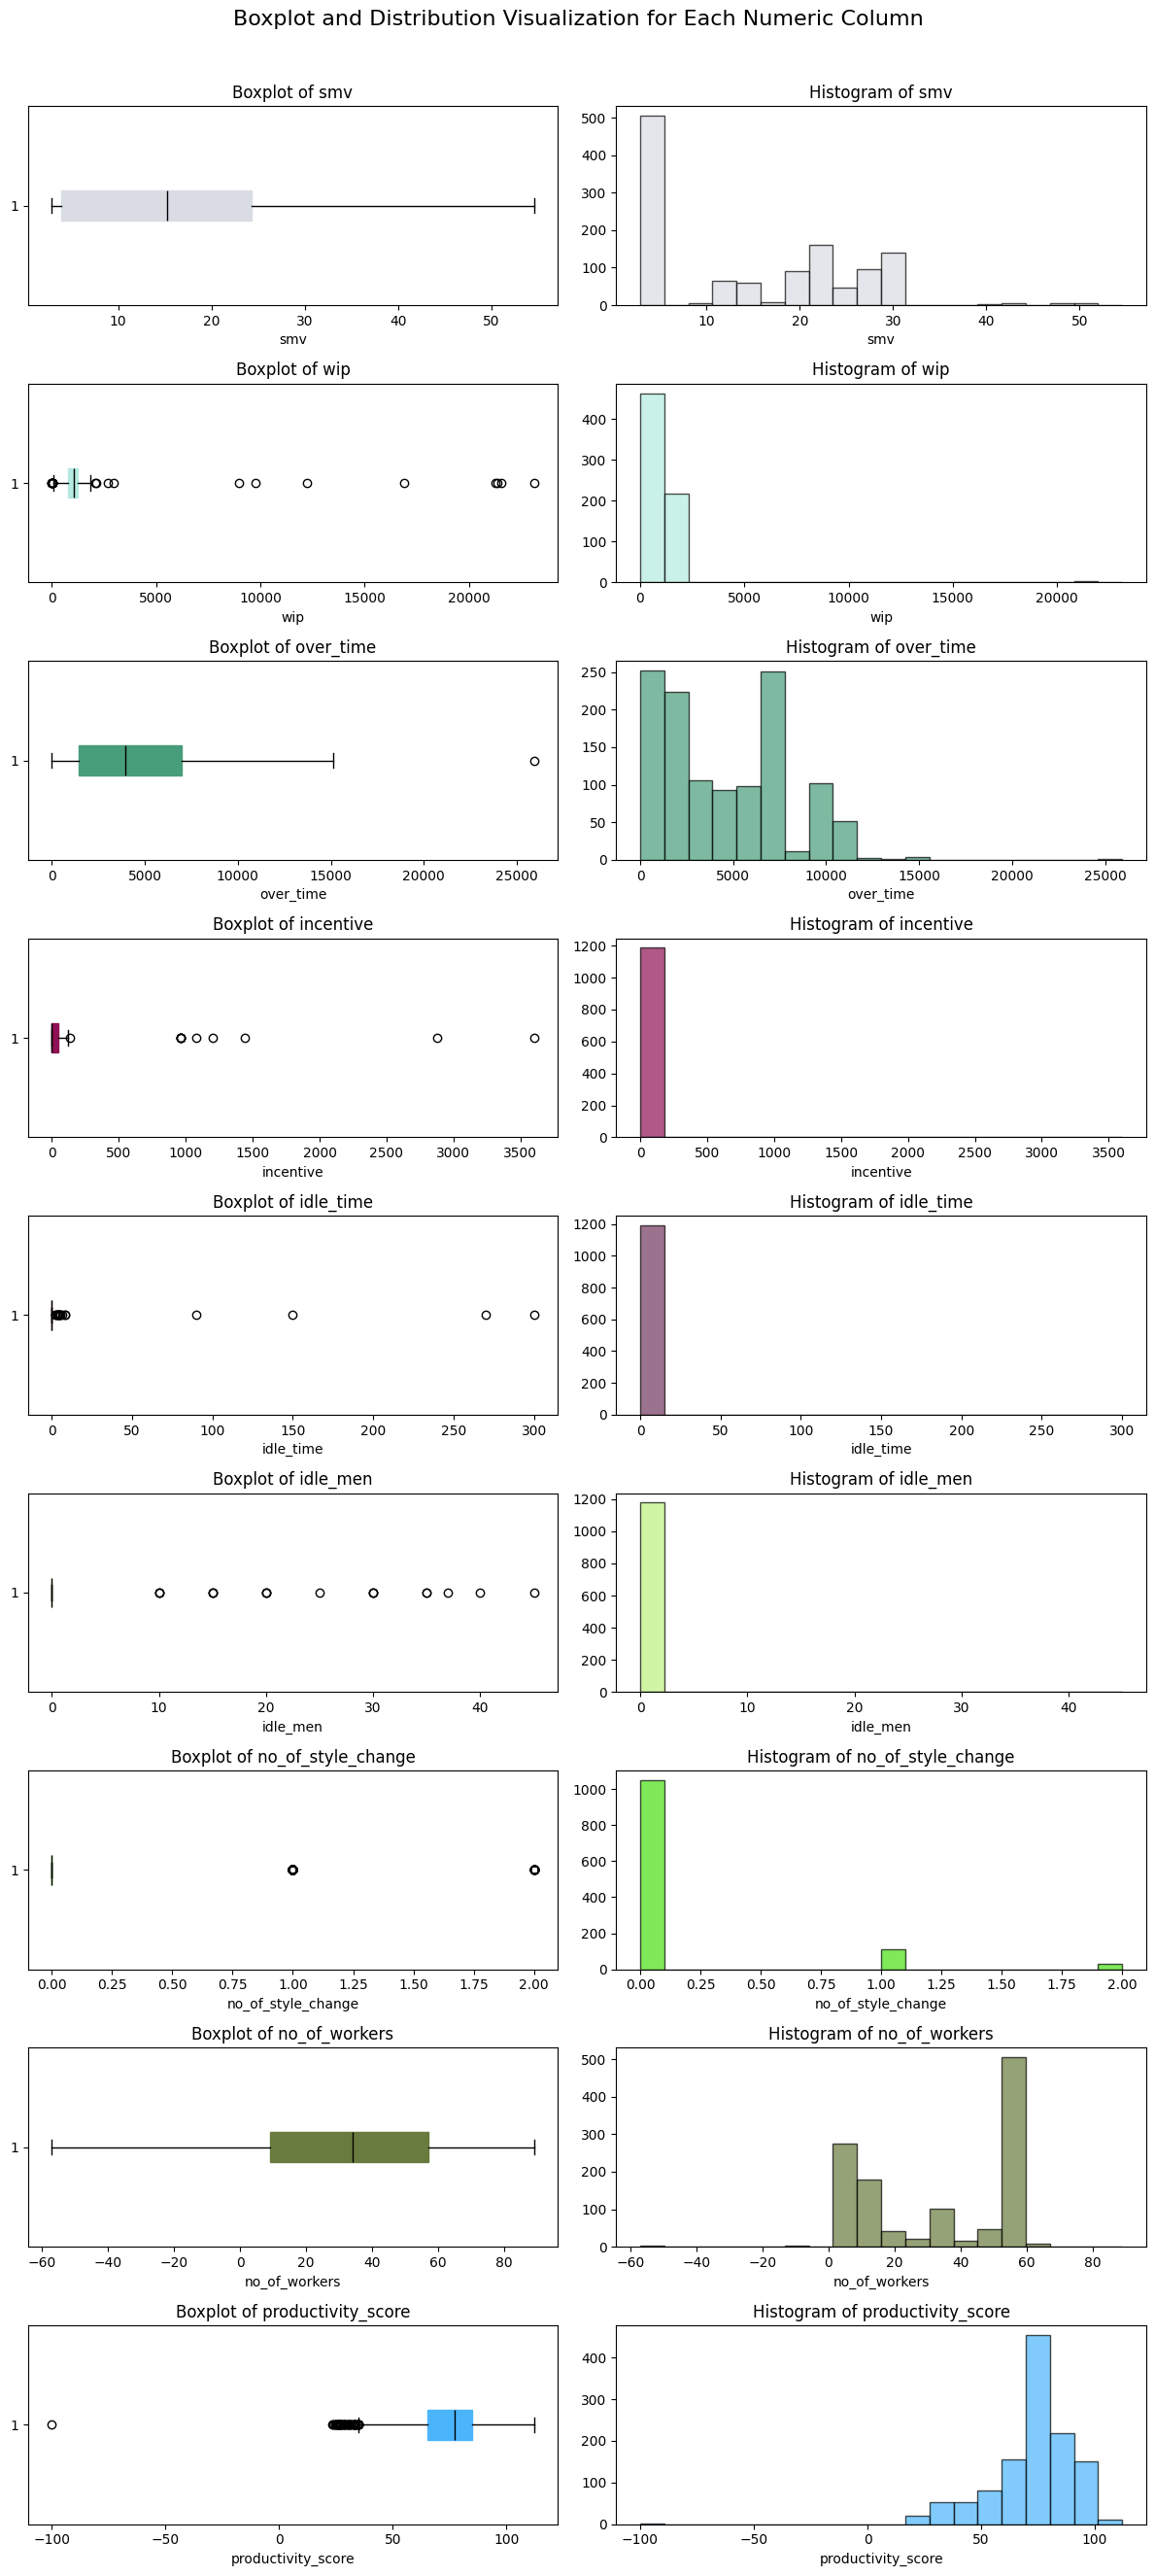

In [22]:
numeric_dist_plot(numeric_data)

#### Categorical Data Plot

In [23]:
categorical_data.head()

,date,quarter,day,Team Code
0,2015-01-01,Quarter1,Thursday,8
1,2015-01-01,Quarter1,Thursday,1
2,2015-01-01,Quarter1,Thursday,11
3,2015-01-01,Quarter1,Thursday,12
4,2015-01-01,Quarter1,Thursday,6


<module 'matplotlib.pyplot' from 'c:\\Users\\Panther\\anaconda3\\envs\\pytorch_env\\Lib\\site-packages\\matplotlib\\pyplot.py'>

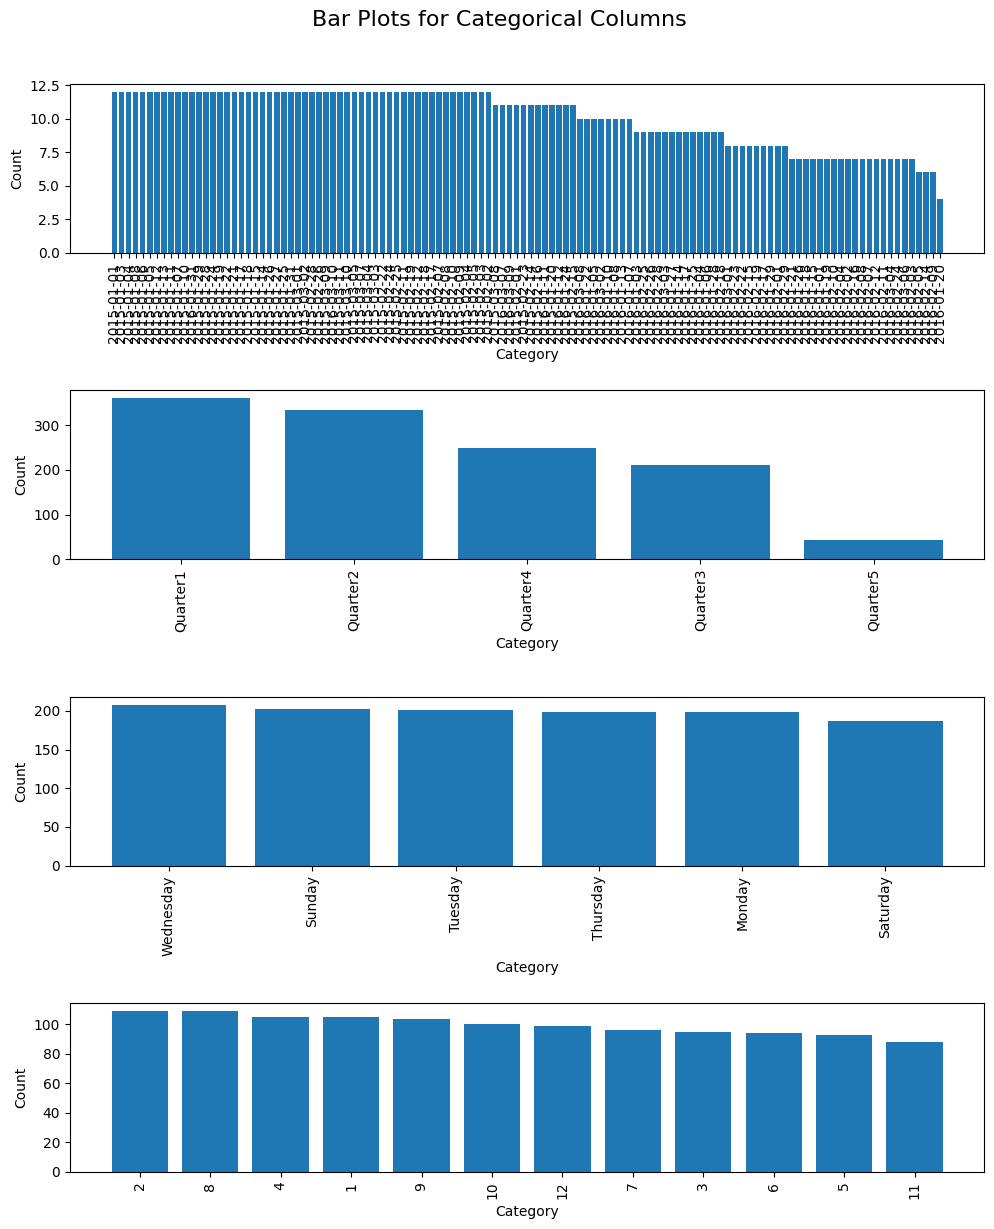

In [24]:
categoric_dist_plot(categorical_data)

## Cleaning the Missing Values

### Attempt: Drop the Missing Values

In [25]:
na_dropped = data.dropna(axis=0)

In [36]:
#check if the missing value is gone
na_dropped.isna().sum()

date                  0
quarter               0
day                   0
Team Code             0
smv                   0
wip                   0
over_time             0
incentive             0
idle_time             0
idle_men              0
no_of_style_change    0
no_of_workers         0
productivity_score    0
dtype: int64

#### Check The distribution

In [26]:
na_dropped_numeric = na_dropped.select_dtypes(include=[np.number])
na_dropped_categorical = na_dropped.select_dtypes(exclude=[np.number])

<module 'matplotlib.pyplot' from 'c:\\Users\\Panther\\anaconda3\\envs\\pytorch_env\\Lib\\site-packages\\matplotlib\\pyplot.py'>

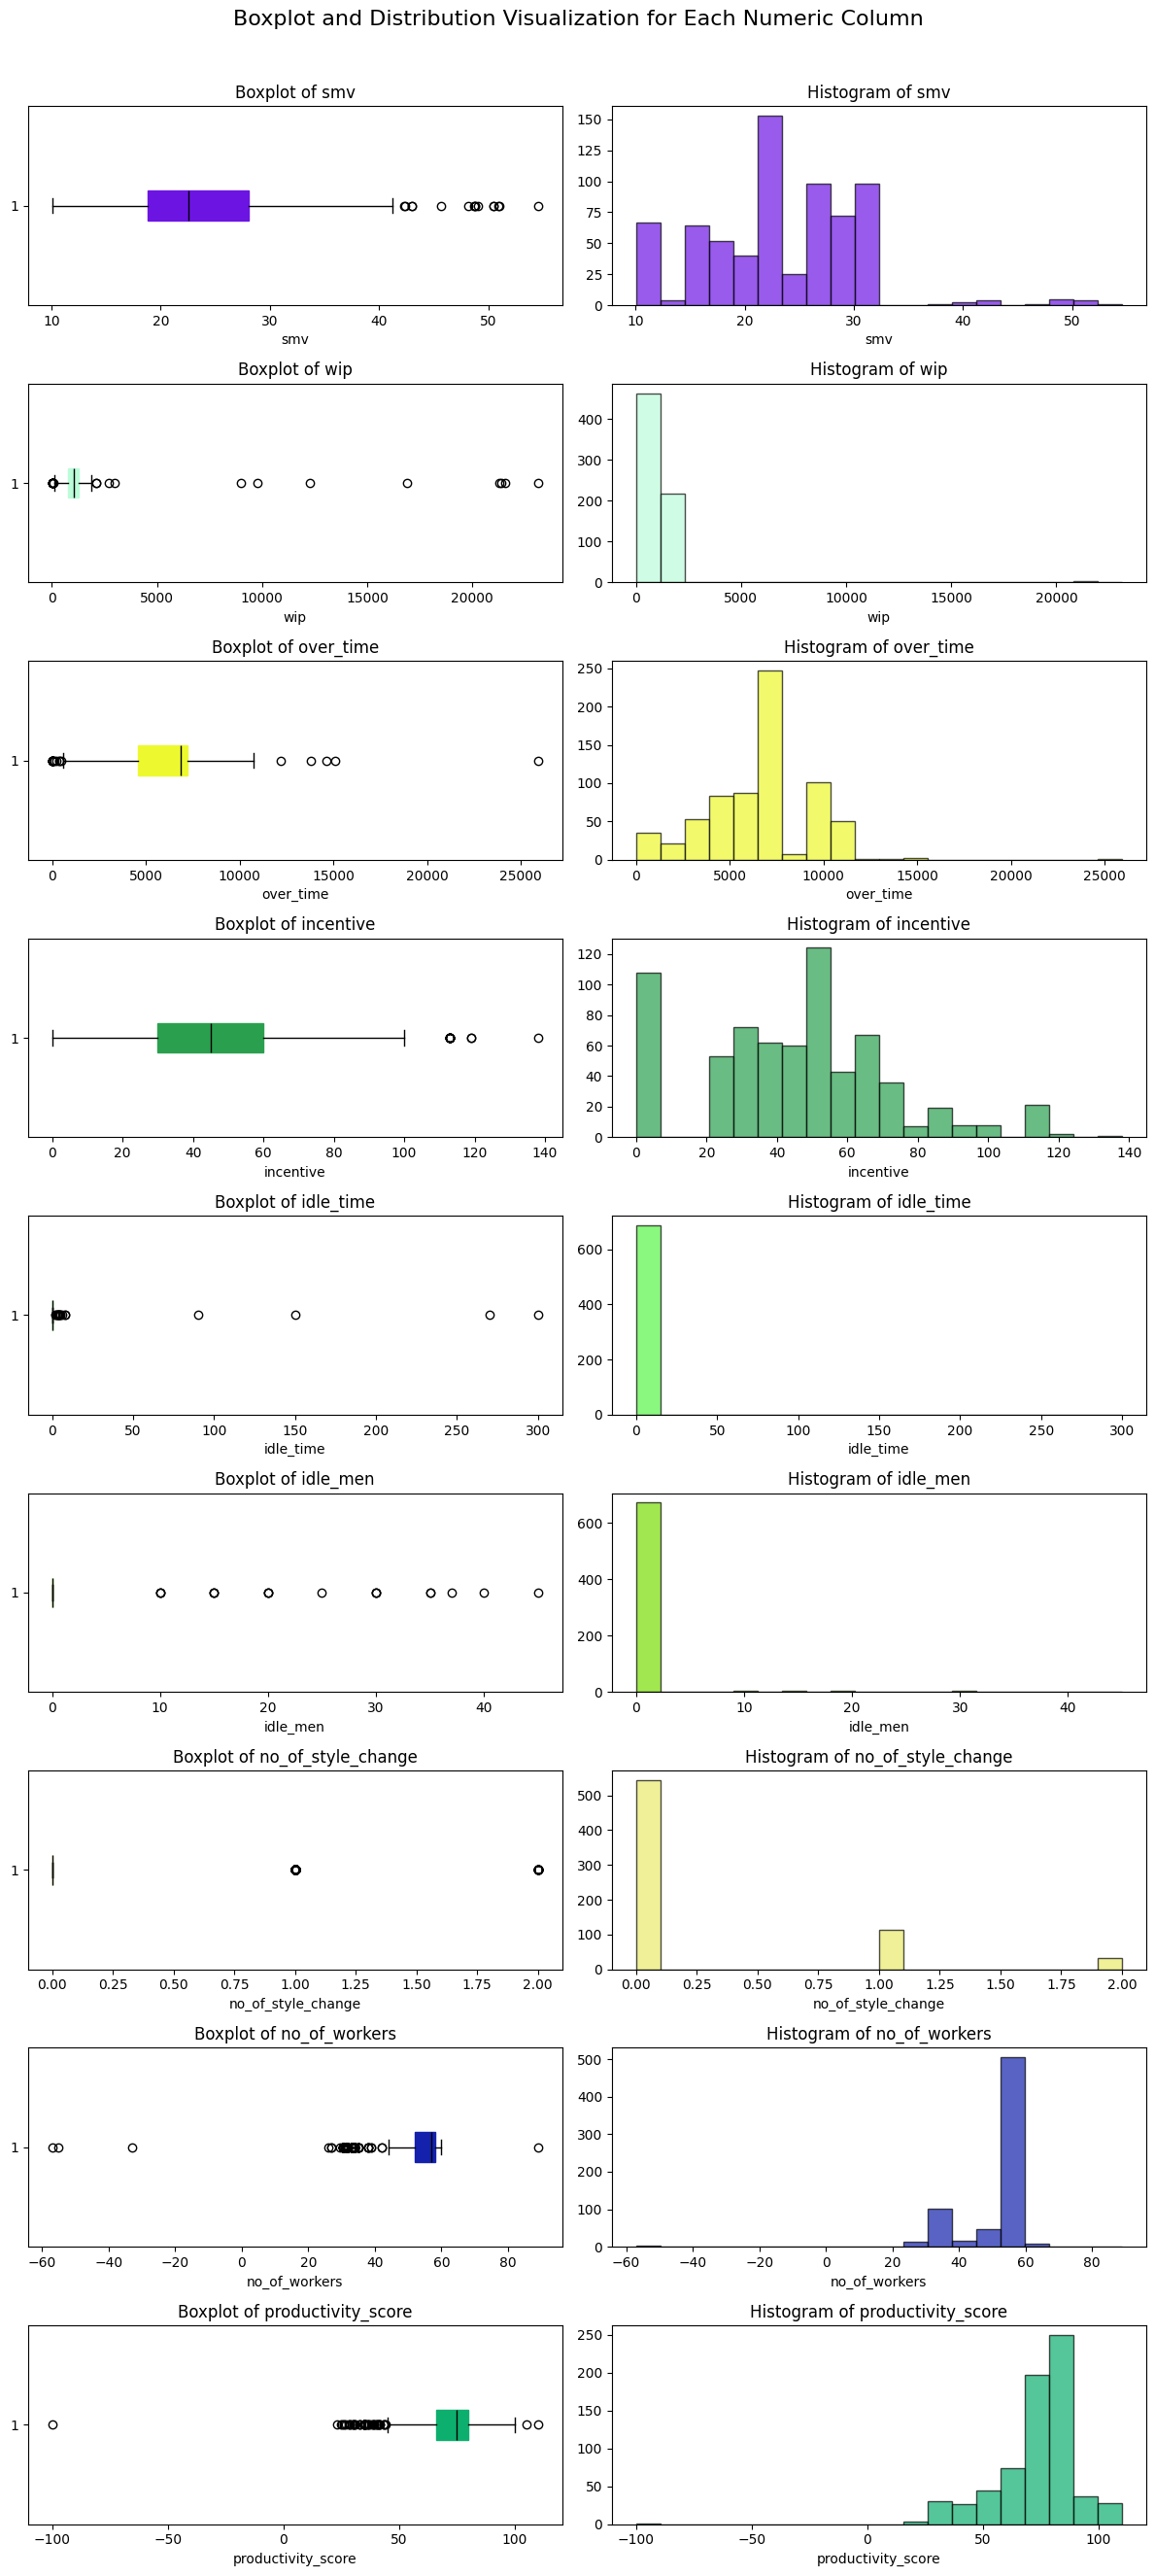

In [27]:
numeric_dist_plot(na_dropped_numeric)

<module 'matplotlib.pyplot' from 'c:\\Users\\Panther\\anaconda3\\envs\\pytorch_env\\Lib\\site-packages\\matplotlib\\pyplot.py'>

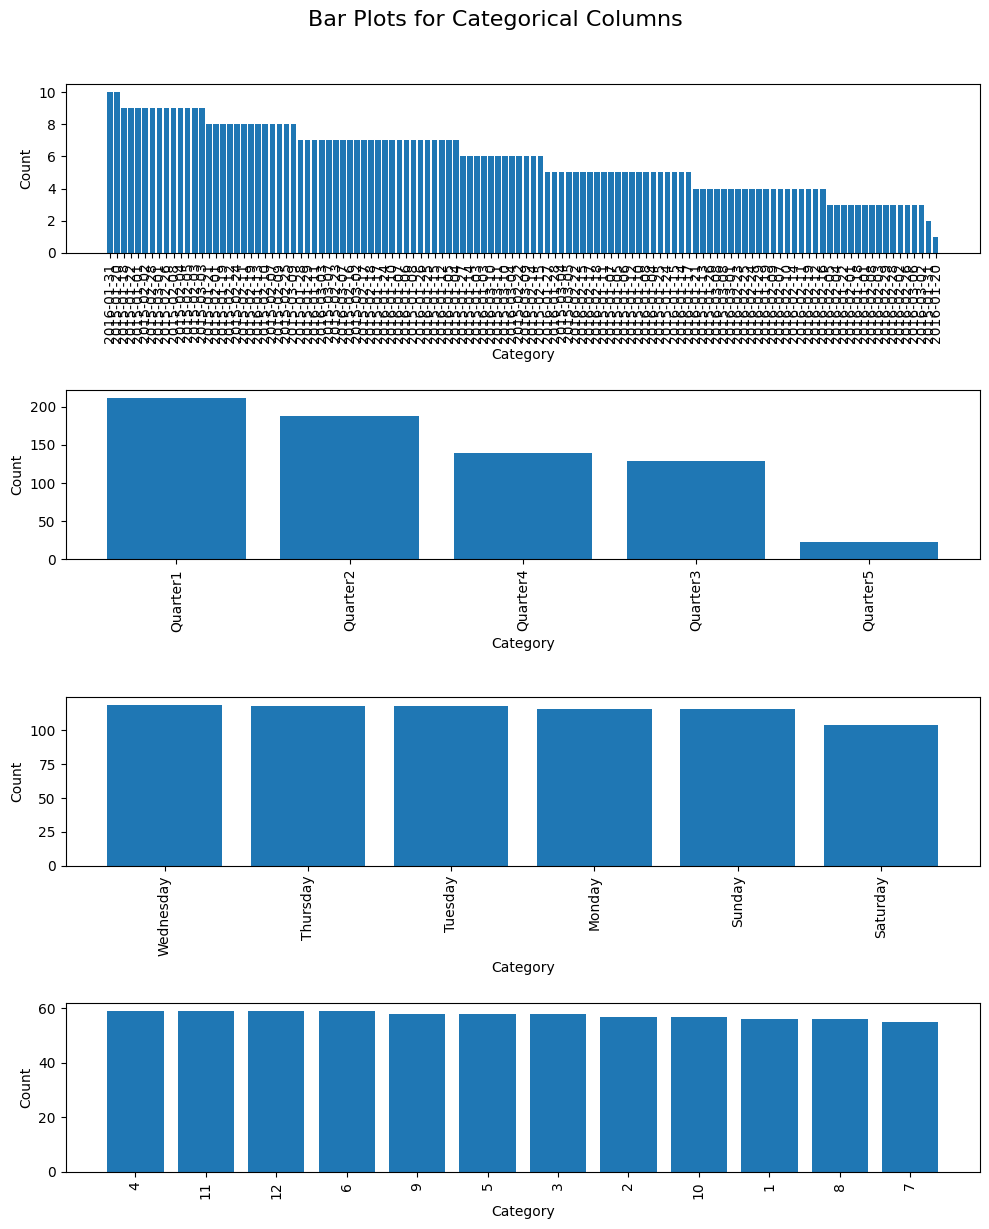

In [28]:
categoric_dist_plot(na_dropped_categorical)

After seeing the distribution, it is best to not to drop the missing values, since there are around 40% of the data would be dropped. Therefore due to there are missing values in the "WIP"(work in progress) column, lets assume that there are no work in progress happening so the missing values would be filled with 0

### Attempt: Filling Missing Values With in the "WIP" Column

In [34]:
data["wip"] = data["wip"].fillna(0)

In [35]:
#check for missing values
data.isna().sum()

date                  0
quarter               0
day                   0
Team Code             0
smv                   0
wip                   0
over_time             0
incentive             0
idle_time             0
idle_men              0
no_of_style_change    0
no_of_workers         0
productivity_score    0
dtype: int64

#### Check the distribution of the data

In [37]:
numeric_data = data.select_dtypes(include=[np.number])
categorical_data = data.select_dtypes(exclude=[np.number])

<module 'matplotlib.pyplot' from 'c:\\Users\\Panther\\anaconda3\\envs\\pytorch_env\\Lib\\site-packages\\matplotlib\\pyplot.py'>

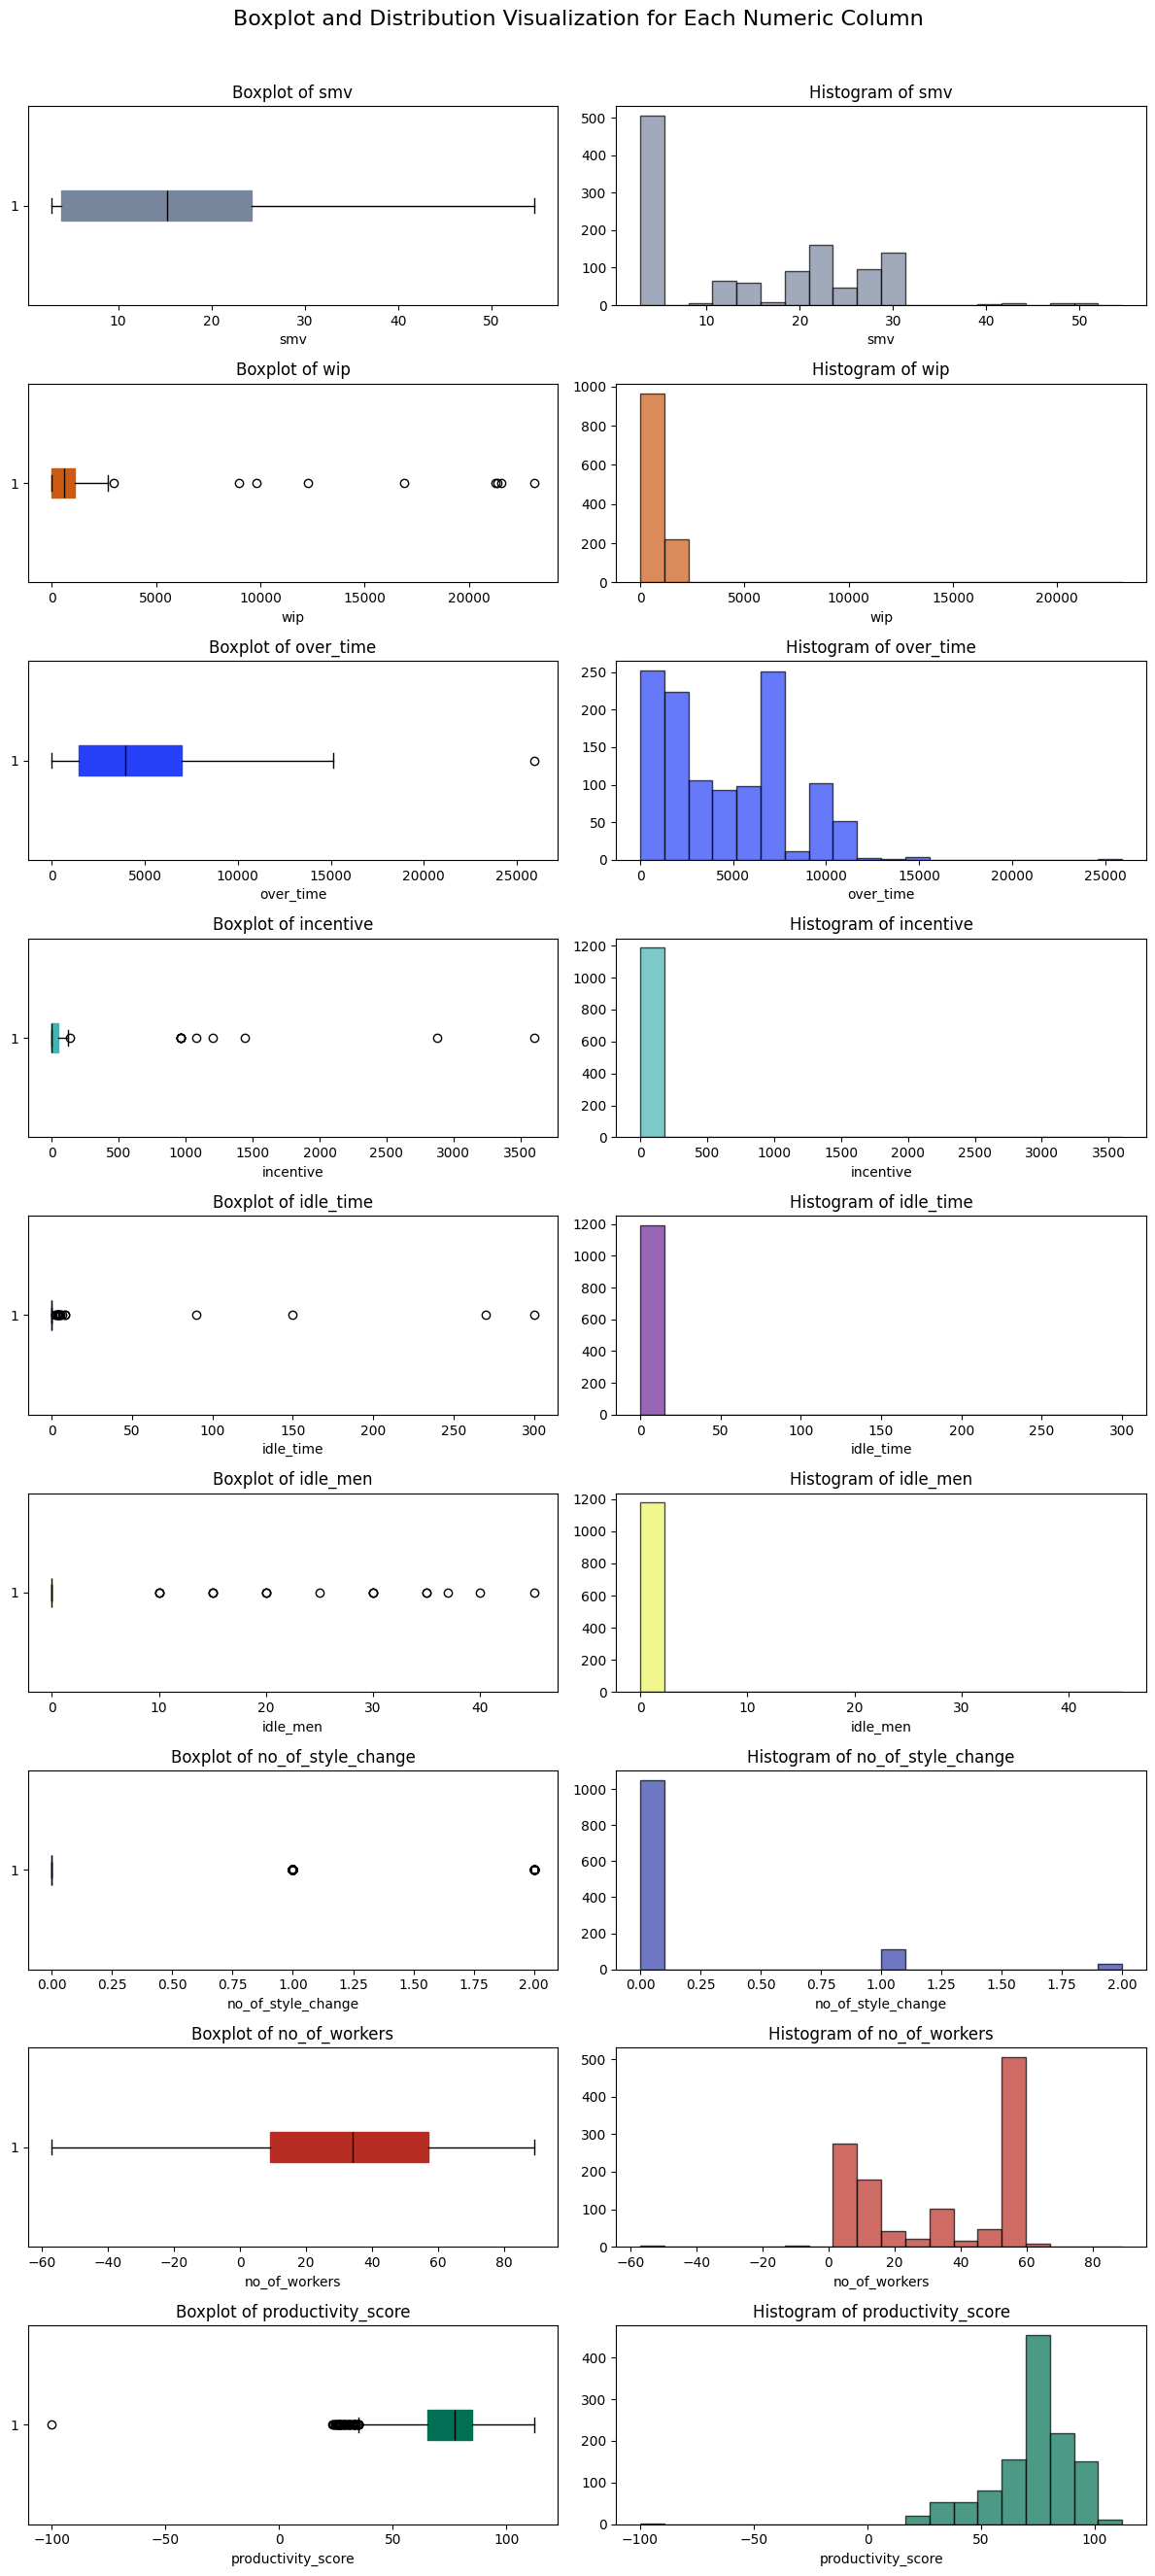

In [38]:
numeric_dist_plot(numeric_data)

<module 'matplotlib.pyplot' from 'c:\\Users\\Panther\\anaconda3\\envs\\pytorch_env\\Lib\\site-packages\\matplotlib\\pyplot.py'>

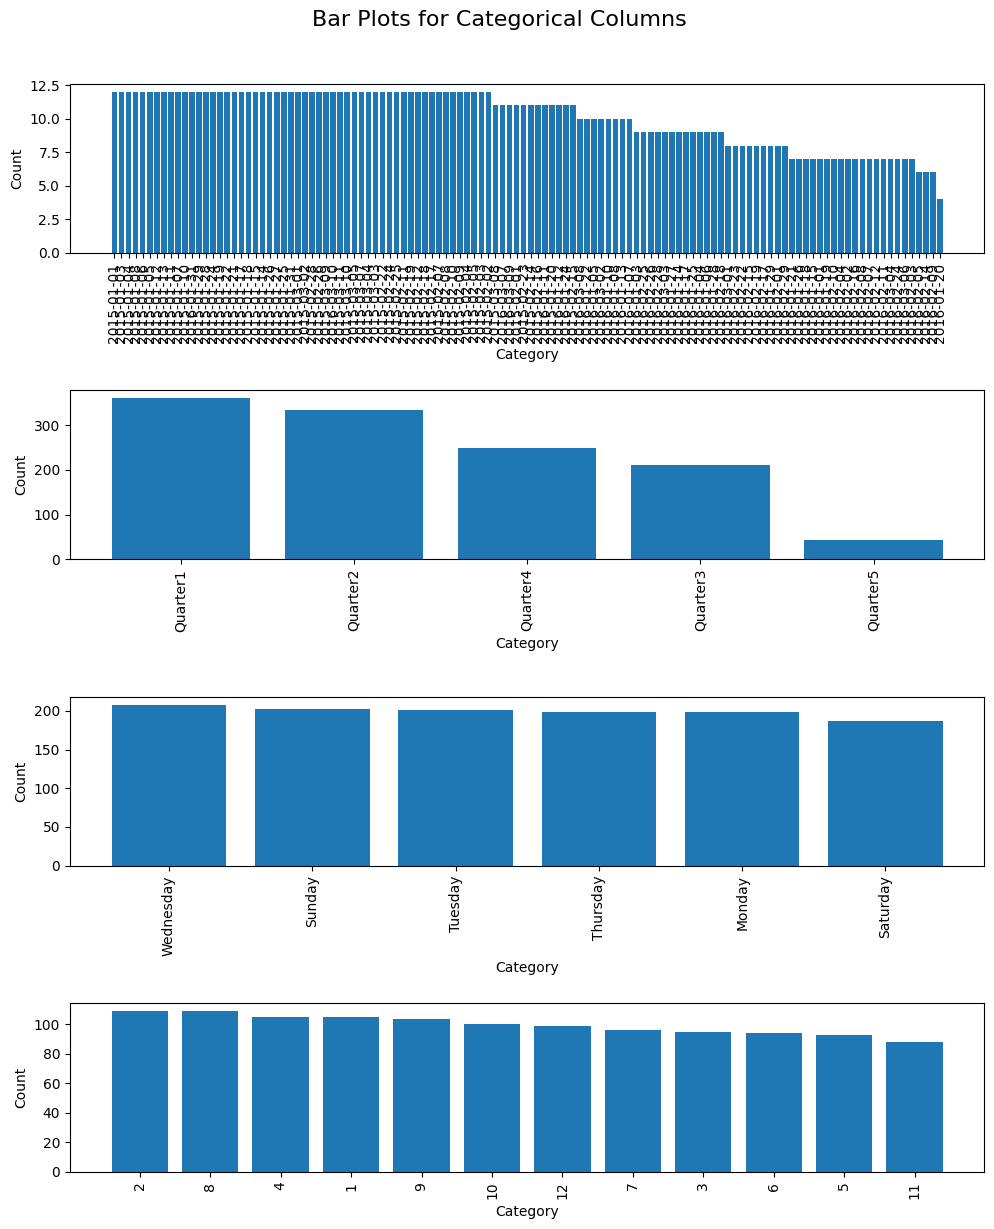

In [39]:
categoric_dist_plot(categorical_data)